In [103]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import os, glob
import geopandas as gpd
import geojsonio
import ipywidgets as widgets
from ipywidgets import interact, interactive
import math
%matplotlib inline

In [104]:
# Dashboard
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
pd.set_option('display.max_colwidth', 150)
sns.set(style="white")

In [105]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [106]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

# Data Exploration

In [107]:
# Separate/create variables for numerical and categorical features
num_features = list(data.columns[data.dtypes!=object])
cat_features = list(data.columns[data.dtypes==object])
#data_cont = data[num_features]

In [108]:
# Examine shape and head/columns of data
print(data.shape)
data.head(1)

(23896, 46)


,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighbourhood,price,review_scores_rating,room_type,security_deposit,space,summary,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",Washer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit""...",221,1.0,1.0,2.0,1,strict_14_with_grace_period,1,This beautiful first floor apartment is situated at Kollwitzplatz. Its ideal for 2 but can comfortably accommodate 4 with the extra double bed i...,20.0,2,t,f,1,f,t,52.535,13.41758,1125,62,1,Fabulous Flat in great Location,Prenzlauer Berg,90.0,93.0,Entire home/apt,1,1,This beautiful first floor apartment is situated at Kollwitzplatz. Its ideal for 2 but can comfortably accommodate 4 with the extra double bed i...,1,zip_10405


In [109]:
# Display interactive map for displaying all values > x for chosen numerical column
@interact
def filter_data(column=num_features, x=(0,1000,10)):
    return data.loc[data[column]>x]

interactive(children=(Dropdown(description='column', options=('accommodates', 'am_balcony', 'am_breakfast', 'a…

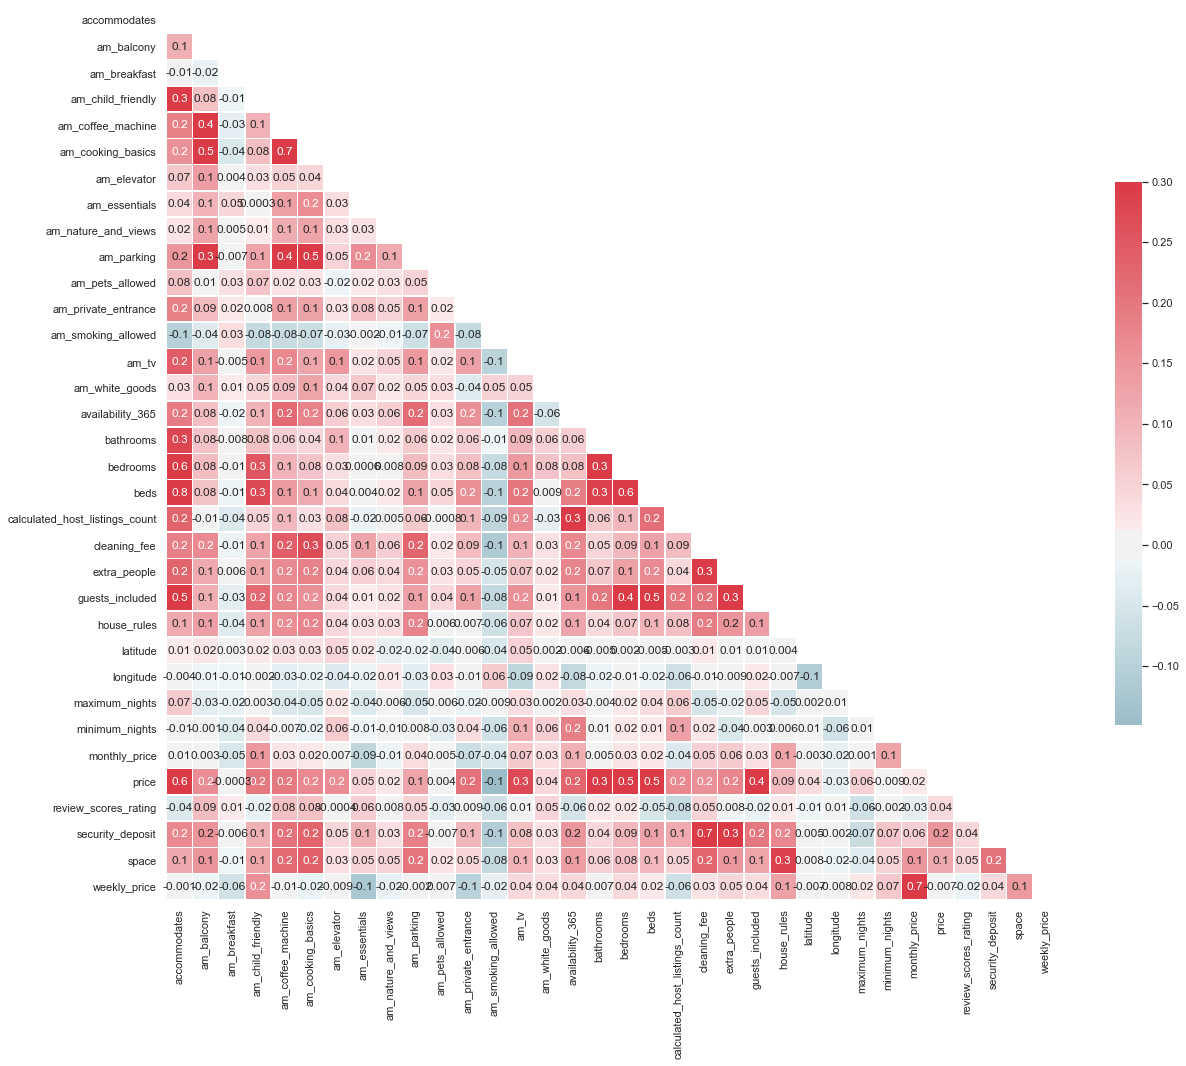

In [110]:
# Plot correlation heatmap for numerical features
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data[num_features].corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data[num_features].corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

Highly correlated features will be removed from the analysis. For this purpose, the threshold is set at two correlations of 0.4 or above. Hence, the following features are removed:

| **FEATURE** | **REASONING** |
| :----- | :----- |
| **am_cooking_basics** | Particularly high correlation with **am_coffee_machine** and **am_balcony** |
| **bedroom** and **beds** | High correlation with each other, with **accommodates** and similar correlation with other features |
| **guests_included** | High correlation with many features |
| **security_deposit** and **space** | Similar correlation to **cleaning_fee** or **extra_people**: Potentially make a numerical feature counting amount of "special" features instead (0-4) |
| **** |  |



In [111]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data.skew()

accommodates                      2.453446
am_balcony                        1.709562
am_breakfast                      4.033108
am_child_friendly                 0.906018
am_coffee_machine                 0.947025
am_cooking_basics                 0.571207
am_elevator                       1.399258
am_essentials                    -3.049737
am_nature_and_views               6.200305
am_parking                        0.336803
am_pets_allowed                   1.842440
am_private_entrance               1.902239
am_smoking_allowed                1.599799
am_tv                             0.219946
am_white_goods                   -1.994215
availability_365                  1.701717
bathrooms                         4.697665
bedrooms                          2.106290
beds                              3.692875
calculated_host_listings_count    6.561627
cleaning_fee                     -0.921814
extra_people                      3.887531
guests_included                   4.874047
house_rules

Based on skew, log shall replace the original feature for:

| **FEATURE** |
| :----- |
| **accommodates** |
| **bathrooms** |
| **minimum_nights** |
| **price** |
| **review_scores_rating** |


In [112]:
# Plot histogram of skewed feature
#data.review_scores_rating.plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

In [113]:
# Create log "xyz_log" for numerical feature "xyz"
#data["review_scores_rating_log"] = [math.log(el) for el in data.review_scores_rating]

In [114]:
# Plot histogram of "xyz_log"
#data["review_scores_rating_log"].plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');

In [115]:
# List correlation values
data.corr()

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cleaning_fee,extra_people,guests_included,house_rules,latitude,longitude,maximum_nights,minimum_nights,monthly_price,price,review_scores_rating,security_deposit,space,weekly_price
accommodates,1.000000,0.110039,-0.010185,0.301374,0.183153,0.159249,0.065779,0.037357,0.023972,0.151880,0.080877,0.183632,-0.100083,0.242428,0.032667,0.193881,0.279691,0.645182,0.782252,0.227408,0.187445,0.228344,0.547228,0.117083,0.014048,-0.003875,0.065053,-0.011154,0.010088,0.599538,-0.041147,0.172173,0.121141,-0.001069
am_balcony,0.110039,1.000000,-0.019759,0.081204,0.429043,0.528809,0.136519,0.101482,0.125484,0.307484,0.012338,0.087993,-0.035946,0.129203,0.103260,0.083746,0.076103,0.084585,0.078833,-0.011188,0.169158,0.115746,0.107590,0.134452,0.021051,-0.012689,-0.032983,-0.001295,0.003080,0.165233,0.088410,0.153450,0.149837,-0.015345
am_breakfast,-0.010185,-0.019759,1.000000,-0.013380,-0.026188,-0.043961,0.004392,0.045946,0.004862,-0.007150,0.028387,0.018018,0.034986,-0.005311,0.013211,-0.015505,-0.008335,-0.010306,-0.014361,-0.040751,-0.013834,0.006083,-0.031170,-0.036385,0.003431,-0.013275,-0.021604,-0.036899,-0.047110,-0.000346,0.013737,-0.006215,-0.012410,-0.059144
am_child_friendly,0.301374,0.081204,-0.013380,1.000000,0.104027,0.083821,0.030608,0.000251,0.014091,0.127964,0.074808,0.007668,-0.080054,0.142455,0.046045,0.102880,0.077809,0.253075,0.272086,0.048415,0.128135,0.127243,0.222835,0.131533,0.016554,-0.002465,0.003300,0.039473,0.147392,0.197185,-0.019674,0.105664,0.125877,0.160454
am_coffee_machine,0.183153,0.429043,-0.026188,0.104027,1.000000,0.673558,0.053688,0.135006,0.113994,0.406241,0.023399,0.134105,-0.075382,0.172547,0.085925,0.220629,0.060708,0.100170,0.141455,0.096488,0.239427,0.168880,0.174508,0.161937,0.028795,-0.032989,-0.042121,-0.006961,0.026295,0.197476,0.081914,0.208860,0.220444,-0.010170
am_cooking_basics,0.159249,0.528809,-0.043961,0.083821,0.673558,1.000000,0.044533,0.162779,0.127427,0.450711,0.025214,0.131640,-0.069929,0.122976,0.126305,0.180602,0.042408,0.076490,0.115325,0.029797,0.267715,0.182410,0.157833,0.179918,0.029966,-0.022015,-0.049465,-0.016943,0.017053,0.173615,0.082336,0.227788,0.234429,-0.020542
am_elevator,0.065779,0.136519,0.004392,0.030608,0.053688,0.044533,1.000000,0.033746,0.033855,0.049896,-0.015044,0.025795,-0.025119,0.147394,0.040791,0.060435,0.102757,0.030907,0.040439,0.079297,0.053844,0.041616,0.037421,0.040889,0.048010,-0.041850,0.017765,0.061979,0.007239,0.163601,-0.000386,0.045164,0.031469,-0.009455
am_essentials,0.037357,0.101482,0.045946,0.000251,0.135006,0.162779,0.033746,1.000000,0.029085,0.163745,0.015167,0.082209,-0.001835,0.022276,0.069127,0.033815,0.011631,0.000557,0.004399,-0.019957,0.126390,0.057448,0.013989,0.033392,0.018331,-0.017667,-0.040576,-0.012268,-0.088669,0.050209,0.060833,0.106398,0.049434,-0.121610
am_nature_and_views,0.023972,0.125484,0.004862,0.014091,0.113994,0.127427,0.033855,0.029085,1.000000,0.115784,0.029626,0.054418,-0.012774,0.048290,0.019096,0.057020,0.015051,0.008477,0.018962,0.004676,0.058682,0.040052,0.024079,0.033933,-0.024619,0.014883,-0.006235,-0.010291,-0.014424,0.020263,0.008078,0.032332,0.049810,-0.021232
am_parking,0.151880,0.307484,-0.007150,0.127964,0.406241,0.450711,0.049896,0.163745,0.115784,1.000000,0.050636,0.131739,-0.066325,0.145595,0.045643,0.218003,0.063666,0.087565,0.130659,0.063817,0.229285,0.155144,0.133124,0.178476,-0.015854,-0.034503,-0.049325,0.008471,0.035555,0.126328,0.051206,0.186748,0.204761,-0.002057


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


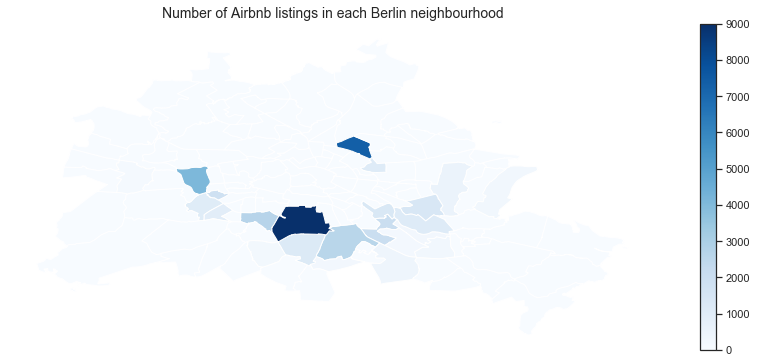

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


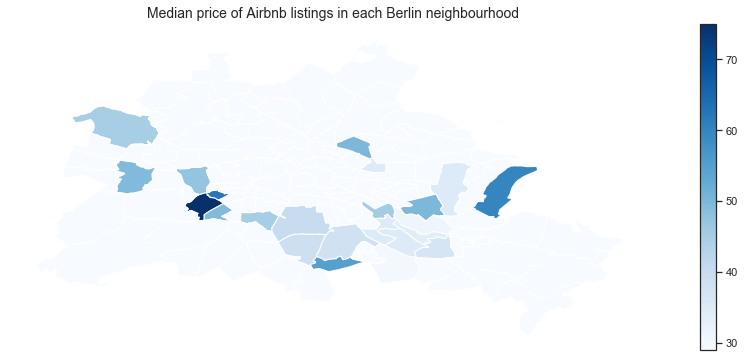

In [116]:
# Display contents of neighbourhoods.geojson visually (not working properly, ON HOLD)

# Load up the file
data_2019_12_11_neighb_geojson = gpd.read_file('data/2019-12-11/neighbourhoods.geojson')

# Dropping the redundant column
data_2019_12_11_neighb_geojson.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
neighbourhood_df = pd.DataFrame(data.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = data.groupby('neighbourhood').price.median().values

# Joining the dataframes
neighbourhood_map_df = data_2019_12_11_neighb_geojson.set_index('neighbourhood').join(neighbourhood_df)

# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()